In [1]:
# setup and imports

import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_io import load_excel_data, clean_observations, get_annual_summary, calculate_shannon_diversity

# set some plotting defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
data = load_excel_data('../data/raw/Observations 2012-2025.xlsx')
df_obs = data['observations']
df_species = data['species']
df_gps = data['gps']
# Import additional libraries needed for analysis
from scipy import stats
from scipy.stats import shapiro
import statsmodels.api as sm

# Clean the observations data
df_clean = clean_observations(df_obs)

# Filter data for years 2015-2024
df_filtered = df_clean[(df_clean['year'] >= 2015) & (df_clean['year'] <= 2024)].copy()

print(f"Filtered data for years 2015-2024: {len(df_filtered)} observations")
print(f"Year range: {df_filtered['year'].min()} - {df_filtered['year'].max()}")
print(f"Unique species: {df_filtered['species_name'].nunique()}")
print(f"Unique years: {sorted(df_filtered['year'].unique())}")

Loading data from ../data/raw/Observations 2012-2025.xlsx
Loaded 86 species
Loaded 651 GPS points
Converting count columns to numeric
Loaded 114497 observation records
Data Cleaning
Starting with 114497 records
⚠ Found 5 negative wind values - setting to NaN
Removed 4 records with zero/negative counts
Final dataset: 114493 records
  Years: 2014 - 2025
  Unique species: 102
  Unique transects: 72
  Unique observers: 42
Filtered data for years 2015-2024: 99344 observations
Year range: 2015 - 2024
Unique species: 98
Unique years: [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


In [3]:
# Indicator 1: Species Richness
# Calculate the number of unique species observed per year

annual_richness = []

for year in sorted(df_filtered['year'].unique()):
    df_year = df_filtered[df_filtered['year'] == year]
    
    # Species richness = number of unique species in the year
    richness = df_year['species_name'].nunique()
    
    annual_richness.append({
        'year': year,
        'species_richness': richness
    })

# Create DataFrame with annual richness values
df_richness = pd.DataFrame(annual_richness)
df_richness = df_richness.sort_values('year').reset_index(drop=True)

print("Annual Species Richness (2015-2024):")
print(df_richness.to_string(index=False))
print(f"\nMean richness: {df_richness['species_richness'].mean():.1f}")
print(f"Range: {df_richness['species_richness'].min()} - {df_richness['species_richness'].max()}")


Annual Species Richness (2015-2024):
 year  species_richness
 2015                70
 2016                77
 2017                71
 2018                73
 2019                70
 2020                68
 2021                69
 2022                68
 2023                67
 2024                70

Mean richness: 70.3
Range: 67 - 77


In [9]:
# Indicator 2: Shannon Diversity
# Calculate Shannon diversity index per year
# H' = -Σ(p_i * ln(p_i)), where p_i = proportion of individuals per species

annual_shannon = []

for year in sorted(df_filtered['year'].unique()):
    df_year = df_filtered[df_filtered['year'] == year]
    
    # Calculate Shannon diversity using the imported function
    shannon = calculate_shannon_diversity(df_year)
    
    annual_shannon.append({
        'year': year,
        'shannon_diversity': shannon
    })

# Create DataFrame with annual Shannon diversity values
df_shannon = pd.DataFrame(annual_shannon)
df_shannon = df_shannon.sort_values('year').reset_index(drop=True)

print("Annual Shannon Diversity (2015-2024):")
print(df_shannon.to_string(index=False))
print(f"\nMean Shannon diversity: {df_shannon['shannon_diversity'].mean():.3f}")
print(f"Range: {df_shannon['shannon_diversity'].min():.3f} - {df_shannon['shannon_diversity'].max():.3f}")


Annual Shannon Diversity (2015-2024):
 year  shannon_diversity
 2015           3.062091
 2016           3.053396
 2017           3.020512
 2018           2.999394
 2019           3.014705
 2020           3.043480
 2021           3.045896
 2022           3.036786
 2023           3.057674
 2024           3.043292

Mean Shannon diversity: 3.038
Range: 2.999 - 3.062


In [10]:
# Indicator 3: Total Abundance
# Calculate the total number of individuals observed per year

annual_abundance = []

for year in sorted(df_filtered['year'].unique()):
    df_year = df_filtered[df_filtered['year'] == year]
    
    # Total abundance = sum of all individual counts in the year
    total_abundance = df_year['individual_count'].sum()
    
    annual_abundance.append({
        'year': year,
        'total_abundance': total_abundance
    })

# Create DataFrame with annual total abundance values
df_abundance = pd.DataFrame(annual_abundance)
df_abundance = df_abundance.sort_values('year').reset_index(drop=True)

print("Annual Total Abundance (2015-2024):")
print(df_abundance.to_string(index=False))
print(f"\nMean total abundance: {df_abundance['total_abundance'].mean():,.0f}")
print(f"Range: {df_abundance['total_abundance'].min():,.0f} - {df_abundance['total_abundance'].max():,.0f}")

Annual Total Abundance (2015-2024):
 year  total_abundance
 2015     52453.000000
 2016     69062.000000
 2017     61685.380952
 2018     61208.000000
 2019     63217.000000
 2020     66171.000000
 2021     72048.000000
 2022     73549.000000
 2023     67057.000000
 2024     65395.000000

Mean total abundance: 65,185
Range: 52,453 - 73,549


In [11]:
# Indicator 4: Mean Abundance per Point
# Calculate mean abundance per observation point per year
# This standardizes for sampling effort by dividing total abundance by number of unique points

annual_mean_abundance = []

for year in sorted(df_filtered['year'].unique()):
    df_year = df_filtered[df_filtered['year'] == year]
    
    # Count unique observation points (transect-point combinations)
    n_points = df_year[['transect_name', 'point_number']].drop_duplicates().shape[0]
    
    # Total abundance
    total_abundance = df_year['individual_count'].sum()
    
    # Mean abundance per point
    if n_points > 0:
        mean_abundance = total_abundance / n_points
    else:
        mean_abundance = 0
    
    annual_mean_abundance.append({
        'year': year,
        'mean_abundance_per_point': mean_abundance,
        'n_points': n_points
    })

# Create DataFrame with annual mean abundance per point values
df_mean_abundance = pd.DataFrame(annual_mean_abundance)
df_mean_abundance = df_mean_abundance.sort_values('year').reset_index(drop=True)

print("Annual Mean Abundance per Point (2015-2024):")
print(df_mean_abundance[['year', 'mean_abundance_per_point', 'n_points']].to_string(index=False))
print(f"\nMean abundance per point: {df_mean_abundance['mean_abundance_per_point'].mean():.2f}")
print(f"Range: {df_mean_abundance['mean_abundance_per_point'].min():.2f} - {df_mean_abundance['mean_abundance_per_point'].max():.2f}")

Annual Mean Abundance per Point (2015-2024):
 year  mean_abundance_per_point  n_points
 2015                 98.967925       530
 2016                117.054237       590
 2017                102.808968       600
 2018                 95.488300       641
 2019                 99.241758       637
 2020                105.033333       630
 2021                114.726115       628
 2022                116.744444       630
 2023                104.940532       639
 2024                100.762712       649

Mean abundance per point: 105.58
Range: 95.49 - 117.05


In [12]:
# Indicator 5: Observer Effort
# Calculate the total number of observations per year (observer effort)

annual_effort = []

for year in sorted(df_filtered['year'].unique()):
    df_year = df_filtered[df_filtered['year'] == year]
    
    # Observer effort = total number of observations in the year
    observer_effort = len(df_year)
    
    annual_effort.append({
        'year': year,
        'observer_effort': observer_effort
    })

# Create DataFrame with annual observer effort values
df_effort = pd.DataFrame(annual_effort)
df_effort = df_effort.sort_values('year').reset_index(drop=True)

print("Annual Observer Effort (2015-2024):")
print(df_effort.to_string(index=False))
print(f"\nMean observer effort: {df_effort['observer_effort'].mean():,.0f} observations/year")
print(f"Range: {df_effort['observer_effort'].min():,.0f} - {df_effort['observer_effort'].max():,.0f} observations/year")

Annual Observer Effort (2015-2024):
 year  observer_effort
 2015             8162
 2016            11010
 2017             9228
 2018             9733
 2019             9572
 2020             9956
 2021            10604
 2022            10804
 2023            10224
 2024            10051

Mean observer effort: 9,934 observations/year
Range: 8,162 - 11,010 observations/year


In [13]:
# Indicator 6: Spatial Coverage
# Calculate the number of unique transects surveyed per year

annual_spatial = []

for year in sorted(df_filtered['year'].unique()):
    df_year = df_filtered[df_filtered['year'] == year]
    
    # Spatial coverage = number of unique transects surveyed in the year
    transects_surveyed = df_year['transect_name'].nunique()
    
    annual_spatial.append({
        'year': year,
        'transects_surveyed': transects_surveyed
    })

# Create DataFrame with annual spatial coverage values
df_spatial = pd.DataFrame(annual_spatial)
df_spatial = df_spatial.sort_values('year').reset_index(drop=True)

# Calculate spatial coverage as percentage of total transects
total_transects_overall = df_clean['transect_name'].nunique()
df_spatial['spatial_coverage_pct'] = (df_spatial['transects_surveyed'] / total_transects_overall * 100)

print("Annual Spatial Coverage (2015-2024):")
print(df_spatial[['year', 'transects_surveyed', 'spatial_coverage_pct']].to_string(index=False))
print(f"\nTotal transects in dataset: {total_transects_overall}")
print(f"Mean transects surveyed: {df_spatial['transects_surveyed'].mean():.1f}")
print(f"Mean spatial coverage: {df_spatial['spatial_coverage_pct'].mean():.1f}%")
print(f"Range: {df_spatial['transects_surveyed'].min()} - {df_spatial['transects_surveyed'].max()} transects")

Annual Spatial Coverage (2015-2024):
 year  transects_surveyed  spatial_coverage_pct
 2015                  53             73.611111
 2016                  59             81.944444
 2017                  60             83.333333
 2018                  65             90.277778
 2019                  64             88.888889
 2020                  63             87.500000
 2021                  63             87.500000
 2022                  63             87.500000
 2023                  64             88.888889
 2024                  65             90.277778

Total transects in dataset: 72
Mean transects surveyed: 61.9
Mean spatial coverage: 86.0%
Range: 53 - 65 transects


LINEAR REGRESSION MODELS FOR ALL INDICATORS

1. SPECIES RICHNESS MODEL
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     5.121
Date:                Wed, 05 Nov 2025   Prob (F-statistic):             0.0535
Time:                        15:40:55   Log-Likelihood:                -21.863
No. Observations:                  10   AIC:                             47.73
Df Residuals:                       8   BIC:                             48.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

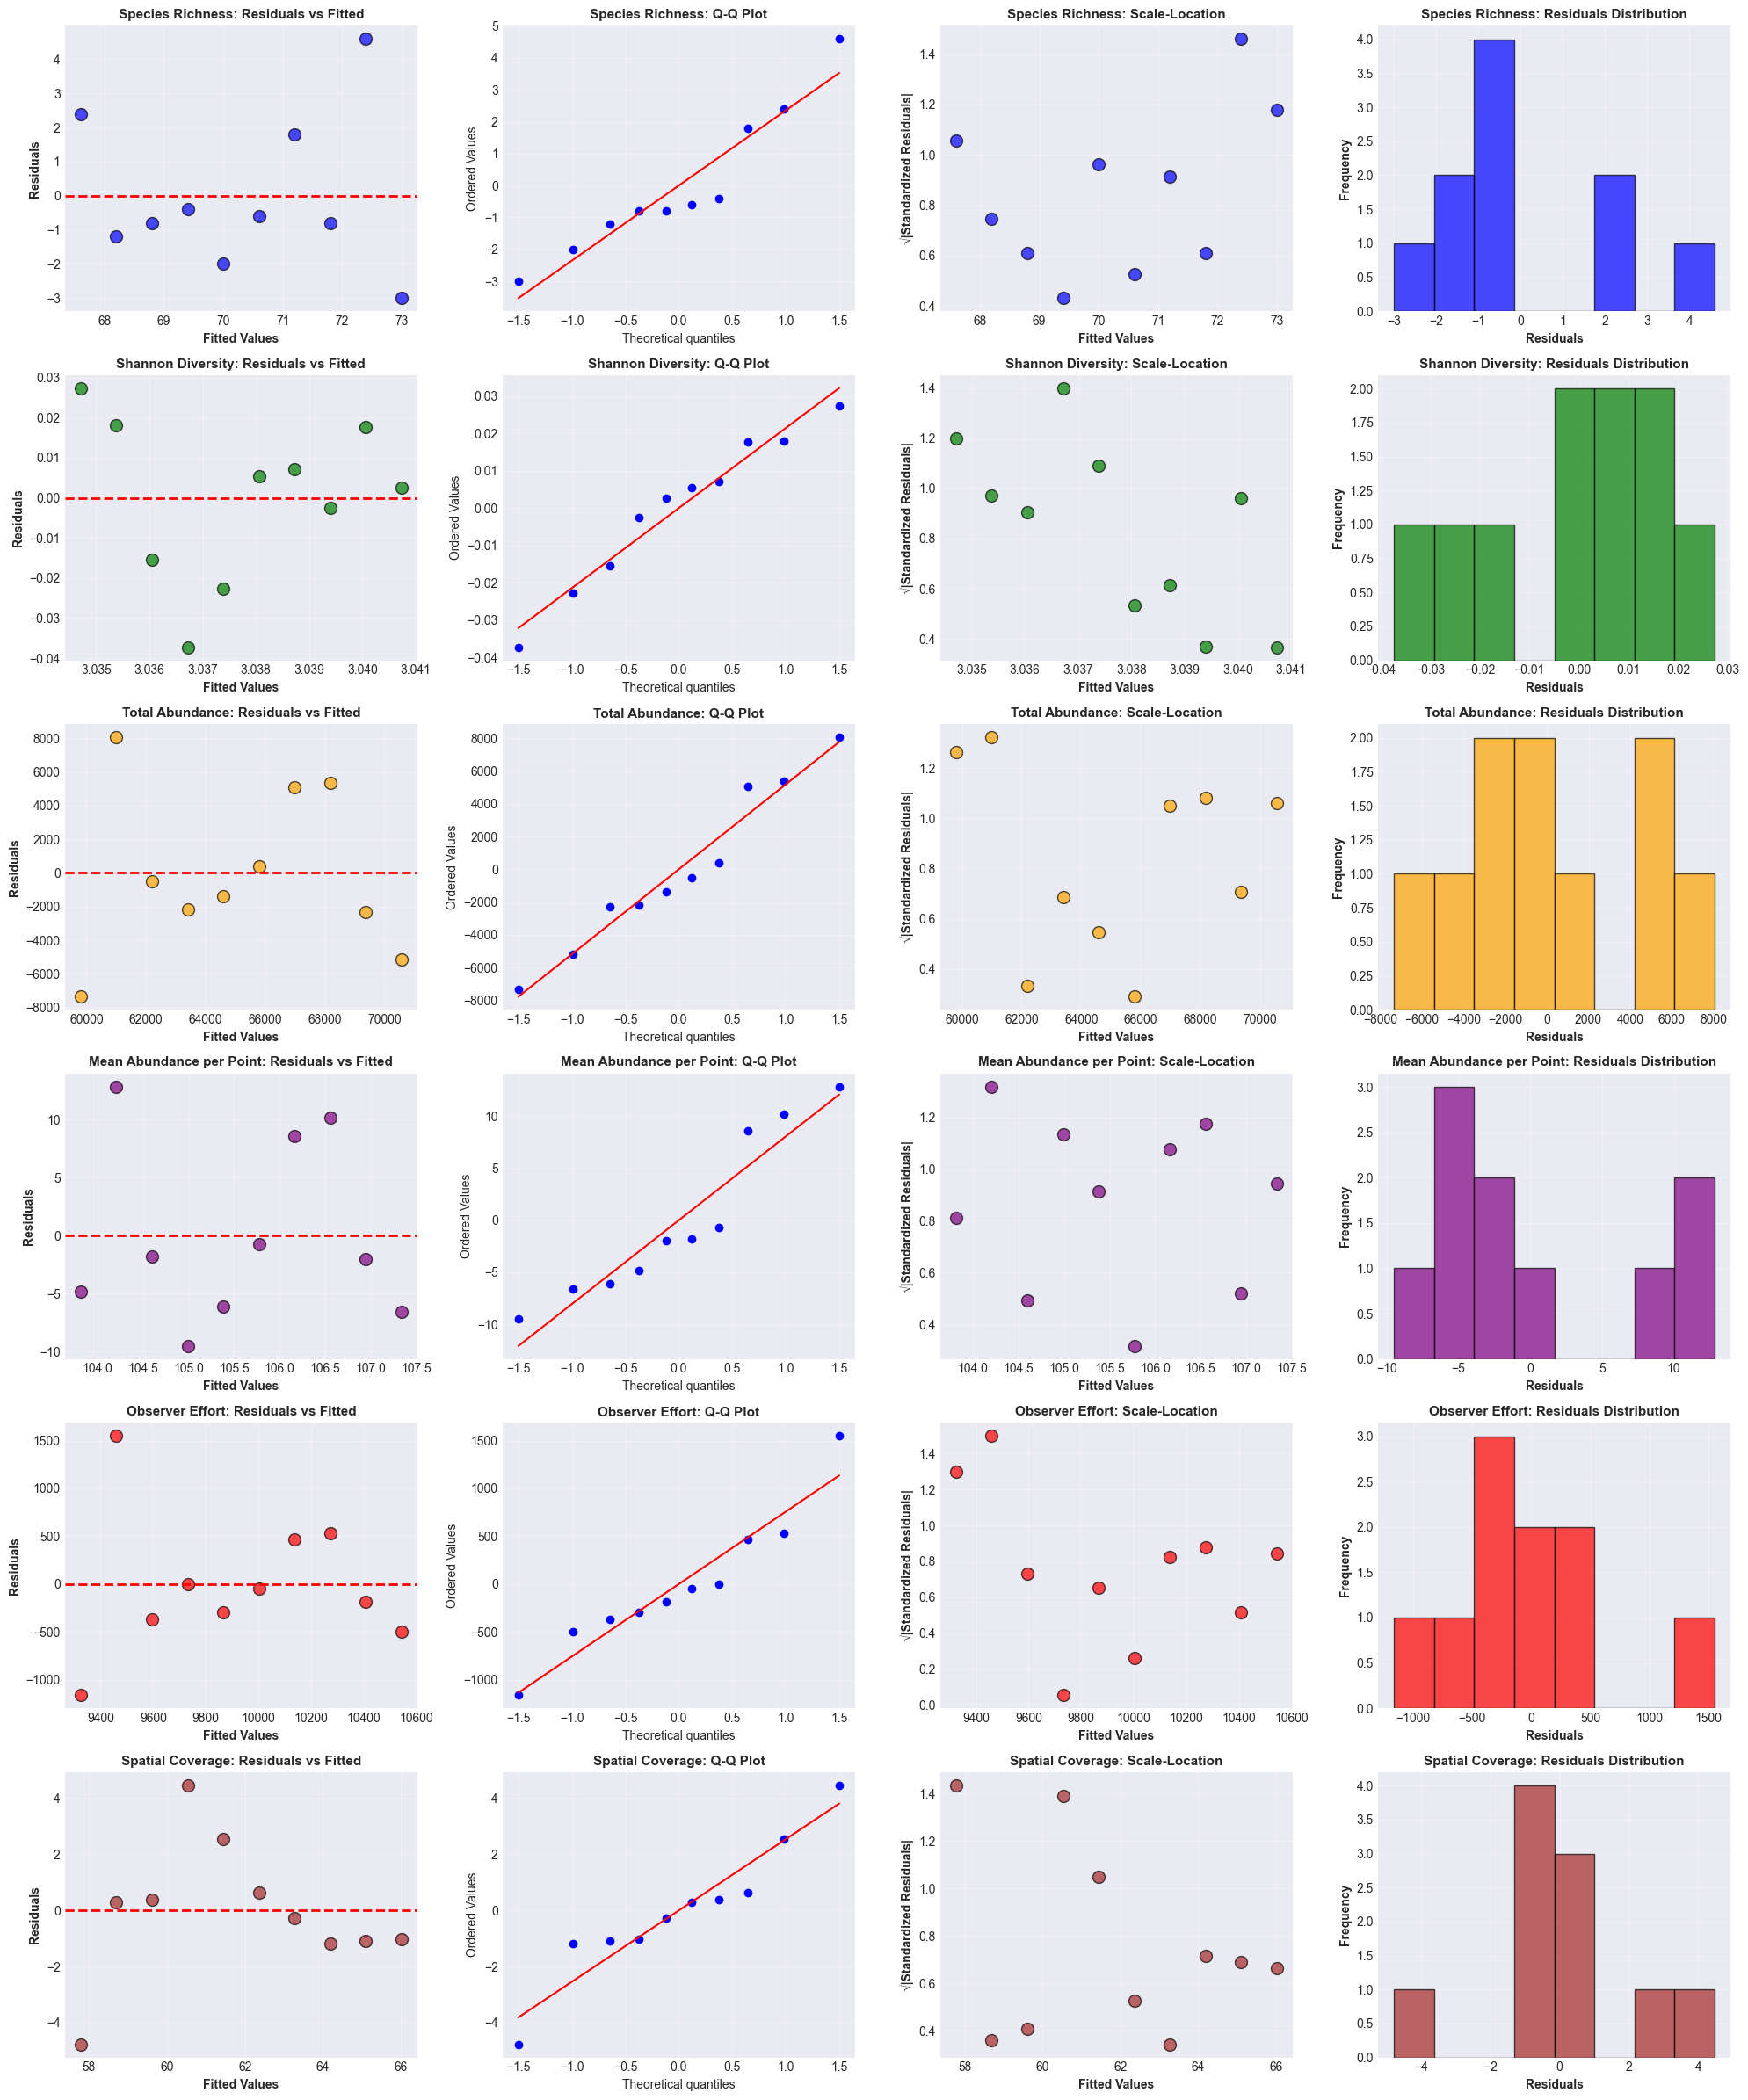


✓ Saved diagnostic plots: ../figures/indicator_model_diagnostics.png


In [14]:
# Model Diagnostics
# Fit linear regression models for all indicators and display diagnostics

# Prepare data for modeling (using year as predictor)
X = sm.add_constant(df_richness['year'].values)

# Dictionary to store all models
models = {}

# Fit models for each indicator
print("=" * 80)
print("LINEAR REGRESSION MODELS FOR ALL INDICATORS")
print("=" * 80)
print()

# 1. Species Richness
y_richness = df_richness['species_richness'].values
model_richness = sm.OLS(y_richness, X).fit()
models['Species Richness'] = {
    'model': model_richness,
    'data': df_richness,
    'y_col': 'species_richness',
    'color': 'blue'
}

print("1. SPECIES RICHNESS MODEL")
print(model_richness.summary())
print("\n" + "-" * 80 + "\n")

# 2. Shannon Diversity
y_shannon = df_shannon['shannon_diversity'].values
model_shannon = sm.OLS(y_shannon, X).fit()
models['Shannon Diversity'] = {
    'model': model_shannon,
    'data': df_shannon,
    'y_col': 'shannon_diversity',
    'color': 'green'
}

print("2. SHANNON DIVERSITY MODEL")
print(model_shannon.summary())
print("\n" + "-" * 80 + "\n")

# 3. Total Abundance
y_abundance = df_abundance['total_abundance'].values
model_abundance = sm.OLS(y_abundance, X).fit()
models['Total Abundance'] = {
    'model': model_abundance,
    'data': df_abundance,
    'y_col': 'total_abundance',
    'color': 'orange'
}

print("3. TOTAL ABUNDANCE MODEL")
print(model_abundance.summary())
print("\n" + "-" * 80 + "\n")

# 4. Mean Abundance per Point
y_mean_abundance = df_mean_abundance['mean_abundance_per_point'].values
model_mean_abundance = sm.OLS(y_mean_abundance, X).fit()
models['Mean Abundance per Point'] = {
    'model': model_mean_abundance,
    'data': df_mean_abundance,
    'y_col': 'mean_abundance_per_point',
    'color': 'purple'
}

print("4. MEAN ABUNDANCE PER POINT MODEL")
print(model_mean_abundance.summary())
print("\n" + "-" * 80 + "\n")

# 5. Observer Effort
y_effort = df_effort['observer_effort'].values
model_effort = sm.OLS(y_effort, X).fit()
models['Observer Effort'] = {
    'model': model_effort,
    'data': df_effort,
    'y_col': 'observer_effort',
    'color': 'red'
}

print("5. OBSERVER EFFORT MODEL")
print(model_effort.summary())
print("\n" + "-" * 80 + "\n")

# 6. Spatial Coverage
y_spatial = df_spatial['transects_surveyed'].values
model_spatial = sm.OLS(y_spatial, X).fit()
models['Spatial Coverage'] = {
    'model': model_spatial,
    'data': df_spatial,
    'y_col': 'transects_surveyed',
    'color': 'brown'
}

print("6. SPATIAL COVERAGE MODEL")
print(model_spatial.summary())
print("\n" + "=" * 80 + "\n")

# Create comprehensive diagnostic plots
print("\nDIAGNOSTIC PLOTS")
print("=" * 80)

# Create figure with subplots for all models
# 6 indicators × 4 diagnostic plots = 24 subplots
# Arrange in 6 rows × 4 columns
fig, axes = plt.subplots(6, 4, figsize=(20, 24))

indicator_names = list(models.keys())
colors = ['blue', 'green', 'orange', 'purple', 'red', 'brown']

for idx, (indicator_name, model_info) in enumerate(models.items()):
    model = model_info['model']
    residuals = model.resid
    fitted = model.fittedvalues
    color = colors[idx]
    
    # Row for this indicator
    row = idx
    
    # 1. Residuals vs Fitted
    axes[row, 0].scatter(fitted, residuals, alpha=0.7, s=100, edgecolors='black', color=color)
    axes[row, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[row, 0].set_xlabel('Fitted Values', fontweight='bold', fontsize=10)
    axes[row, 0].set_ylabel('Residuals', fontweight='bold', fontsize=10)
    axes[row, 0].set_title(f'{indicator_name}: Residuals vs Fitted', fontweight='bold', fontsize=11)
    axes[row, 0].grid(True, alpha=0.3)
    
    # 2. Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[row, 1])
    axes[row, 1].set_title(f'{indicator_name}: Q-Q Plot', fontweight='bold', fontsize=11)
    axes[row, 1].grid(True, alpha=0.3)
    
    # 3. Scale-Location Plot
    std_resid = residuals / np.std(residuals)
    sqrt_abs_resid = np.sqrt(np.abs(std_resid))
    axes[row, 2].scatter(fitted, sqrt_abs_resid, alpha=0.7, s=100, edgecolors='black', color=color)
    axes[row, 2].set_xlabel('Fitted Values', fontweight='bold', fontsize=10)
    axes[row, 2].set_ylabel('√|Standardized Residuals|', fontweight='bold', fontsize=10)
    axes[row, 2].set_title(f'{indicator_name}: Scale-Location', fontweight='bold', fontsize=11)
    axes[row, 2].grid(True, alpha=0.3)
    
    # 4. Residuals Histogram
    axes[row, 3].hist(residuals, bins=8, edgecolor='black', alpha=0.7, color=color)
    axes[row, 3].set_xlabel('Residuals', fontweight='bold', fontsize=10)
    axes[row, 3].set_ylabel('Frequency', fontweight='bold', fontsize=10)
    axes[row, 3].set_title(f'{indicator_name}: Residuals Distribution', fontweight='bold', fontsize=11)
    axes[row, 3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/indicator_model_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved diagnostic plots: ../figures/indicator_model_diagnostics.png")


SYNTHESIS & COMPARISON OF INDICATORS

Combined Indicators DataFrame:
 year  Richness  Shannon  Total_Abundance  Mean_Abundance  Observer_Effort  Spatial_Coverage
 2015        70 3.062091     52453.000000       98.967925             8162                53
 2016        77 3.053396     69062.000000      117.054237            11010                59
 2017        71 3.020512     61685.380952      102.808968             9228                60
 2018        73 2.999394     61208.000000       95.488300             9733                65
 2019        70 3.014705     63217.000000       99.241758             9572                64
 2020        68 3.043480     66171.000000      105.033333             9956                63
 2021        69 3.045896     72048.000000      114.726115            10604                63
 2022        68 3.036786     73549.000000      116.744444            10804                63
 2023        67 3.057674     67057.000000      104.940532            10224                64
 

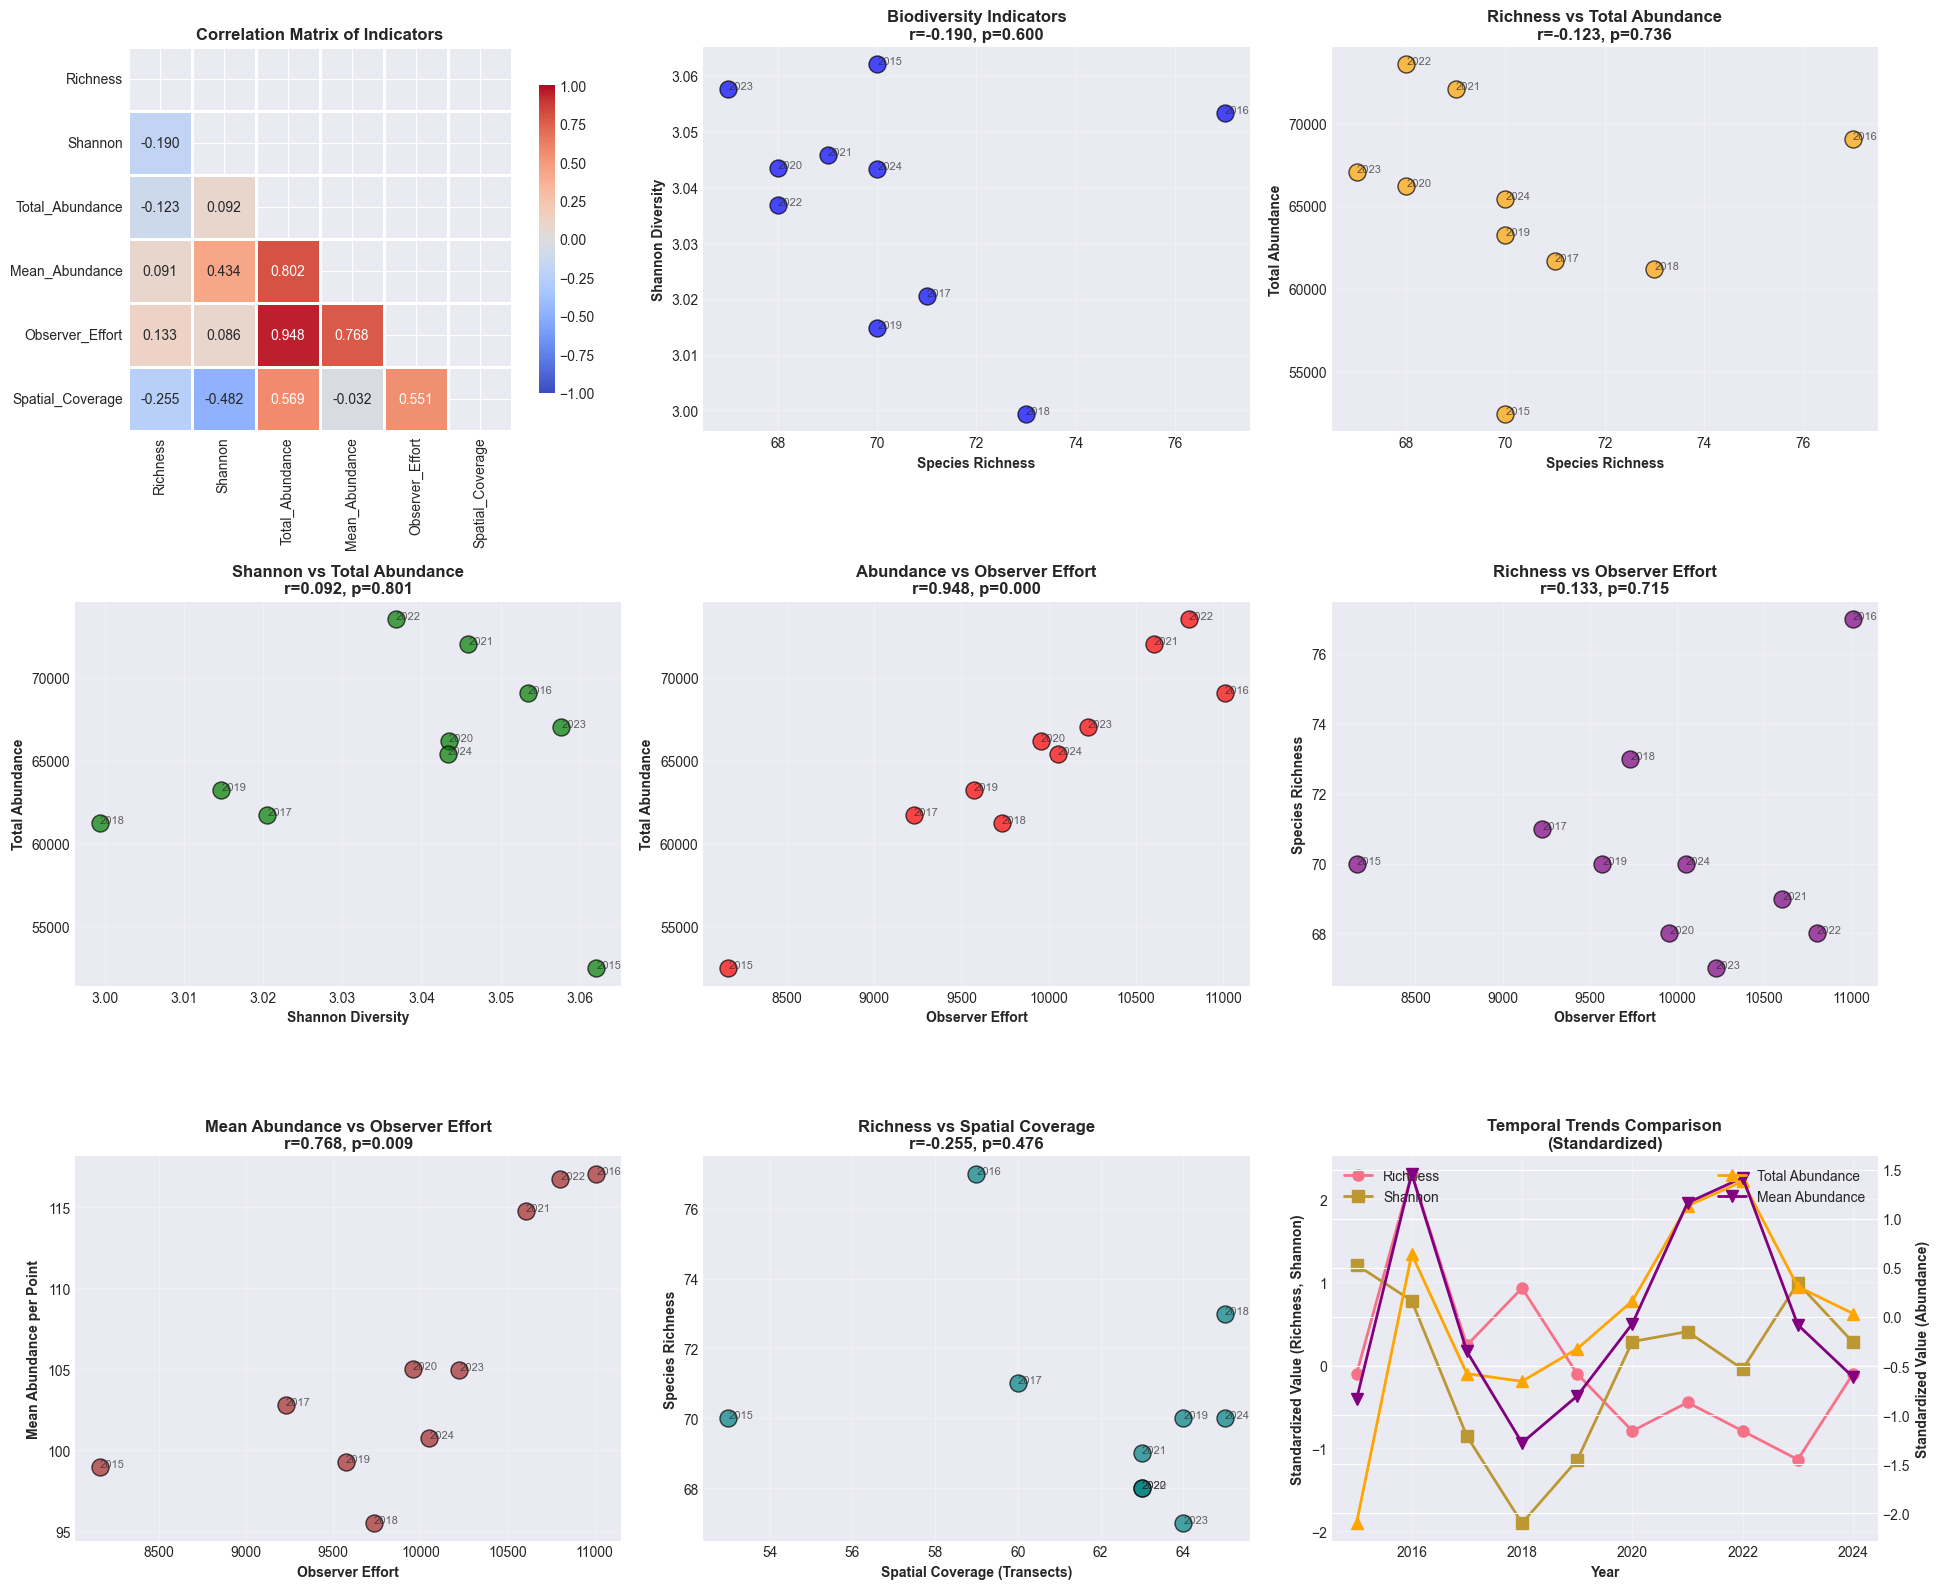


✓ Saved synthesis plots: ../figures/indicator_synthesis_comparison.png

INTERPRETATION & SYNTHESIS


KEY RELATIONSHIPS IDENTIFIED:

1. BIODIVERSITY INDICATORS (Richness vs Shannon):
   • These measure different aspects of diversity
   • Richness: number of species (count)
   • Shannon: species evenness and richness combined
   • Relationship indicates whether diversity is driven by species number or evenness

2. ABUNDANCE VS BIODIVERSITY:
   • Total abundance may increase with richness (more species = more individuals)
   • However, high abundance can also occur with low richness (dominance by few species)
   • Mean abundance per point controls for sampling effort

3. SAMPLING EFFORT EFFECTS:
   • Observer effort and spatial coverage may influence observed richness
   • More effort = more opportunities to detect rare species
   • Need to distinguish true ecological changes from sampling artifacts

4. STANDARDIZED VS RAW METRICS:
   • Mean abundance per point accounts for sampling effo

In [15]:
# Synthesis & Comparison
# Relate indicators to each other and examine relationships

print("=" * 80)
print("SYNTHESIS & COMPARISON OF INDICATORS")
print("=" * 80)
print()

# Merge all indicators into a single DataFrame
df_synthesis = df_richness[['year', 'species_richness']].copy()
df_synthesis = df_synthesis.merge(df_shannon[['year', 'shannon_diversity']], on='year', how='inner')
df_synthesis = df_synthesis.merge(df_abundance[['year', 'total_abundance']], on='year', how='inner')
df_synthesis = df_synthesis.merge(df_mean_abundance[['year', 'mean_abundance_per_point']], on='year', how='inner')
df_synthesis = df_synthesis.merge(df_effort[['year', 'observer_effort']], on='year', how='inner')
df_synthesis = df_synthesis.merge(df_spatial[['year', 'transects_surveyed']], on='year', how='inner')

# Rename columns for clarity
df_synthesis.columns = ['year', 'Richness', 'Shannon', 'Total_Abundance', 
                        'Mean_Abundance', 'Observer_Effort', 'Spatial_Coverage']

print("Combined Indicators DataFrame:")
print(df_synthesis.to_string(index=False))
print()

# Calculate correlation matrix
correlation_matrix = df_synthesis[['Richness', 'Shannon', 'Total_Abundance', 
                                    'Mean_Abundance', 'Observer_Effort', 'Spatial_Coverage']].corr()

print("\n" + "=" * 80)
print("CORRELATION MATRIX")
print("=" * 80)
print(correlation_matrix.round(3))
print()

# Calculate Pearson correlation coefficients and p-values
from scipy.stats import pearsonr

print("=" * 80)
print("DETAILED CORRELATION ANALYSIS")
print("=" * 80)
print()

# Key relationships to examine
key_relationships = [
    ('Richness', 'Shannon', 'Biodiversity indicators'),
    ('Richness', 'Total_Abundance', 'Richness vs Total Abundance'),
    ('Richness', 'Mean_Abundance', 'Richness vs Mean Abundance'),
    ('Shannon', 'Total_Abundance', 'Shannon vs Total Abundance'),
    ('Shannon', 'Mean_Abundance', 'Shannon vs Mean Abundance'),
    ('Total_Abundance', 'Observer_Effort', 'Abundance vs Sampling Effort'),
    ('Total_Abundance', 'Spatial_Coverage', 'Abundance vs Spatial Coverage'),
    ('Mean_Abundance', 'Observer_Effort', 'Mean Abundance vs Sampling Effort'),
    ('Richness', 'Observer_Effort', 'Richness vs Sampling Effort'),
    ('Richness', 'Spatial_Coverage', 'Richness vs Spatial Coverage'),
]

correlations = {}
for var1, var2, label in key_relationships:
    r, p = pearsonr(df_synthesis[var1], df_synthesis[var2])
    correlations[f"{var1}-{var2}"] = {'r': r, 'p': p, 'label': label}
    significance = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
    print(f"{label:40s}: r = {r:6.3f}, p = {p:.4f} {significance}")

print("\n" + "=" * 80)
print("VISUALIZATIONS")
print("=" * 80)

# Create comprehensive visualization figure
fig = plt.figure(figsize=(20, 16))

# 1. Correlation Heatmap
ax1 = plt.subplot(3, 3, 1)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            mask=mask, vmin=-1, vmax=1, ax=ax1)
ax1.set_title('Correlation Matrix of Indicators', fontweight='bold', fontsize=12)

# 2. Biodiversity Indicators (Richness vs Shannon)
ax2 = plt.subplot(3, 3, 2)
ax2.scatter(df_synthesis['Richness'], df_synthesis['Shannon'], 
            s=150, alpha=0.7, edgecolors='black', color='blue')
for idx, row in df_synthesis.iterrows():
    ax2.annotate(int(row['year']), (row['Richness'], row['Shannon']), 
                fontsize=8, alpha=0.7)
r, p = pearsonr(df_synthesis['Richness'], df_synthesis['Shannon'])
ax2.set_xlabel('Species Richness', fontweight='bold')
ax2.set_ylabel('Shannon Diversity', fontweight='bold')
ax2.set_title(f'Biodiversity Indicators\nr={r:.3f}, p={p:.3f}', fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Richness vs Total Abundance
ax3 = plt.subplot(3, 3, 3)
ax3.scatter(df_synthesis['Richness'], df_synthesis['Total_Abundance'], 
            s=150, alpha=0.7, edgecolors='black', color='orange')
for idx, row in df_synthesis.iterrows():
    ax3.annotate(int(row['year']), (row['Richness'], row['Total_Abundance']), 
                fontsize=8, alpha=0.7)
r, p = pearsonr(df_synthesis['Richness'], df_synthesis['Total_Abundance'])
ax3.set_xlabel('Species Richness', fontweight='bold')
ax3.set_ylabel('Total Abundance', fontweight='bold')
ax3.set_title(f'Richness vs Total Abundance\nr={r:.3f}, p={p:.3f}', fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Shannon vs Total Abundance
ax4 = plt.subplot(3, 3, 4)
ax4.scatter(df_synthesis['Shannon'], df_synthesis['Total_Abundance'], 
            s=150, alpha=0.7, edgecolors='black', color='green')
for idx, row in df_synthesis.iterrows():
    ax4.annotate(int(row['year']), (row['Shannon'], row['Total_Abundance']), 
                fontsize=8, alpha=0.7)
r, p = pearsonr(df_synthesis['Shannon'], df_synthesis['Total_Abundance'])
ax4.set_xlabel('Shannon Diversity', fontweight='bold')
ax4.set_ylabel('Total Abundance', fontweight='bold')
ax4.set_title(f'Shannon vs Total Abundance\nr={r:.3f}, p={p:.3f}', fontweight='bold')
ax4.grid(True, alpha=0.3)

# 5. Total Abundance vs Observer Effort
ax5 = plt.subplot(3, 3, 5)
ax5.scatter(df_synthesis['Observer_Effort'], df_synthesis['Total_Abundance'], 
            s=150, alpha=0.7, edgecolors='black', color='red')
for idx, row in df_synthesis.iterrows():
    ax5.annotate(int(row['year']), (row['Observer_Effort'], row['Total_Abundance']), 
                fontsize=8, alpha=0.7)
r, p = pearsonr(df_synthesis['Observer_Effort'], df_synthesis['Total_Abundance'])
ax5.set_xlabel('Observer Effort', fontweight='bold')
ax5.set_ylabel('Total Abundance', fontweight='bold')
ax5.set_title(f'Abundance vs Observer Effort\nr={r:.3f}, p={p:.3f}', fontweight='bold')
ax5.grid(True, alpha=0.3)

# 6. Richness vs Observer Effort
ax6 = plt.subplot(3, 3, 6)
ax6.scatter(df_synthesis['Observer_Effort'], df_synthesis['Richness'], 
            s=150, alpha=0.7, edgecolors='black', color='purple')
for idx, row in df_synthesis.iterrows():
    ax6.annotate(int(row['year']), (row['Observer_Effort'], row['Richness']), 
                fontsize=8, alpha=0.7)
r, p = pearsonr(df_synthesis['Observer_Effort'], df_synthesis['Richness'])
ax6.set_xlabel('Observer Effort', fontweight='bold')
ax6.set_ylabel('Species Richness', fontweight='bold')
ax6.set_title(f'Richness vs Observer Effort\nr={r:.3f}, p={p:.3f}', fontweight='bold')
ax6.grid(True, alpha=0.3)

# 7. Mean Abundance vs Observer Effort
ax7 = plt.subplot(3, 3, 7)
ax7.scatter(df_synthesis['Observer_Effort'], df_synthesis['Mean_Abundance'], 
            s=150, alpha=0.7, edgecolors='black', color='brown')
for idx, row in df_synthesis.iterrows():
    ax7.annotate(int(row['year']), (row['Observer_Effort'], row['Mean_Abundance']), 
                fontsize=8, alpha=0.7)
r, p = pearsonr(df_synthesis['Observer_Effort'], df_synthesis['Mean_Abundance'])
ax7.set_xlabel('Observer Effort', fontweight='bold')
ax7.set_ylabel('Mean Abundance per Point', fontweight='bold')
ax7.set_title(f'Mean Abundance vs Observer Effort\nr={r:.3f}, p={p:.3f}', fontweight='bold')
ax7.grid(True, alpha=0.3)

# 8. Spatial Coverage vs Richness
ax8 = plt.subplot(3, 3, 8)
ax8.scatter(df_synthesis['Spatial_Coverage'], df_synthesis['Richness'], 
            s=150, alpha=0.7, edgecolors='black', color='teal')
for idx, row in df_synthesis.iterrows():
    ax8.annotate(int(row['year']), (row['Spatial_Coverage'], row['Richness']), 
                fontsize=8, alpha=0.7)
r, p = pearsonr(df_synthesis['Spatial_Coverage'], df_synthesis['Richness'])
ax8.set_xlabel('Spatial Coverage (Transects)', fontweight='bold')
ax8.set_ylabel('Species Richness', fontweight='bold')
ax8.set_title(f'Richness vs Spatial Coverage\nr={r:.3f}, p={p:.3f}', fontweight='bold')
ax8.grid(True, alpha=0.3)

# 9. Temporal trends overlay
ax9 = plt.subplot(3, 3, 9)
years = df_synthesis['year'].values
ax9_twin = ax9.twinx()

# Normalize indicators for comparison (z-score)
indicators_normalized = df_synthesis[['Richness', 'Shannon', 'Total_Abundance', 'Mean_Abundance']].copy()
for col in indicators_normalized.columns:
    indicators_normalized[col] = (indicators_normalized[col] - indicators_normalized[col].mean()) / indicators_normalized[col].std()
indicators_normalized = indicators_normalized.values

ax9.plot(years, indicators_normalized[:, 0], 'o-', label='Richness', linewidth=2, markersize=8)
ax9.plot(years, indicators_normalized[:, 1], 's-', label='Shannon', linewidth=2, markersize=8)
ax9_twin.plot(years, indicators_normalized[:, 2], '^-', label='Total Abundance', 
              linewidth=2, markersize=8, color='orange')
ax9_twin.plot(years, indicators_normalized[:, 3], 'v-', label='Mean Abundance', 
              linewidth=2, markersize=8, color='purple')

ax9.set_xlabel('Year', fontweight='bold')
ax9.set_ylabel('Standardized Value (Richness, Shannon)', fontweight='bold')
ax9_twin.set_ylabel('Standardized Value (Abundance)', fontweight='bold')
ax9.set_title('Temporal Trends Comparison\n(Standardized)', fontweight='bold')
ax9.grid(True, alpha=0.3)
ax9.legend(loc='upper left')
ax9_twin.legend(loc='upper right')

plt.tight_layout()
plt.savefig('../figures/indicator_synthesis_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved synthesis plots: ../figures/indicator_synthesis_comparison.png")

# Interpretation
print("\n" + "=" * 80)
print("INTERPRETATION & SYNTHESIS")
print("=" * 80)
print()

interpretation = """
KEY RELATIONSHIPS IDENTIFIED:

1. BIODIVERSITY INDICATORS (Richness vs Shannon):
   • These measure different aspects of diversity
   • Richness: number of species (count)
   • Shannon: species evenness and richness combined
   • Relationship indicates whether diversity is driven by species number or evenness

2. ABUNDANCE VS BIODIVERSITY:
   • Total abundance may increase with richness (more species = more individuals)
   • However, high abundance can also occur with low richness (dominance by few species)
   • Mean abundance per point controls for sampling effort

3. SAMPLING EFFORT EFFECTS:
   • Observer effort and spatial coverage may influence observed richness
   • More effort = more opportunities to detect rare species
   • Need to distinguish true ecological changes from sampling artifacts

4. STANDARDIZED VS RAW METRICS:
   • Mean abundance per point accounts for sampling effort
   • Total abundance may be confounded by observer effort
   • Spatial coverage affects representativeness of surveys

5. TEMPORAL PATTERNS:
   • Compare standardized trends to identify:
     - Parallel trends (indicators changing together)
     - Divergent trends (indicators changing independently)
     - Opposing trends (indicators changing in opposite directions)

ECOLOGICAL INTERPRETATION:
• If richness increases but Shannon decreases → dominance by fewer species
• If abundance increases but richness stable → population growth in common species
• If all metrics increase together → overall community enhancement
• If metrics diverge → community restructuring or methodological issues

METHODOLOGICAL CONSIDERATIONS:
• Strong correlation between abundance and effort suggests sampling bias
• Weak correlation suggests true ecological changes
• Mean abundance per point is more robust to sampling effort variation
"""

print(interpretation)
